In [1]:
import imufusion
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.spatial.transform import Rotation as R

In [2]:
my_data = np.genfromtxt('D:/_xueXi/keCheng/2022S/PHYSCS15CExp/testData0525/accelGyroLog5033170.csv',delimiter=',')

In [3]:
#del my_data[1::2]

In [4]:
timestamp = []
for index, t_interval in enumerate(my_data[:, 0]):
    timestamp.append(sum(my_data[:index, 0]))

In [5]:
t_interval_list = my_data[:, 0]
gyroscopeR = my_data[:, 4:7]
accelerometer = my_data[:, 1:4]

In [6]:
sample_rate = (timestamp[len(timestamp)-1]-timestamp[0])/len(timestamp)

In [7]:
sample_rate

0.014660273299000002

In [8]:
gyroscope = np.degrees(gyroscopeR)

In [9]:
ahrs = imufusion.Ahrs()
euler = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], sample_rate)  # 100 Hz sample rate
    euler[index] = ahrs.quaternion.to_euler()

In [10]:
r = R.from_euler('xyz', euler, degrees=True)
absAccel = r.apply(accelerometer)

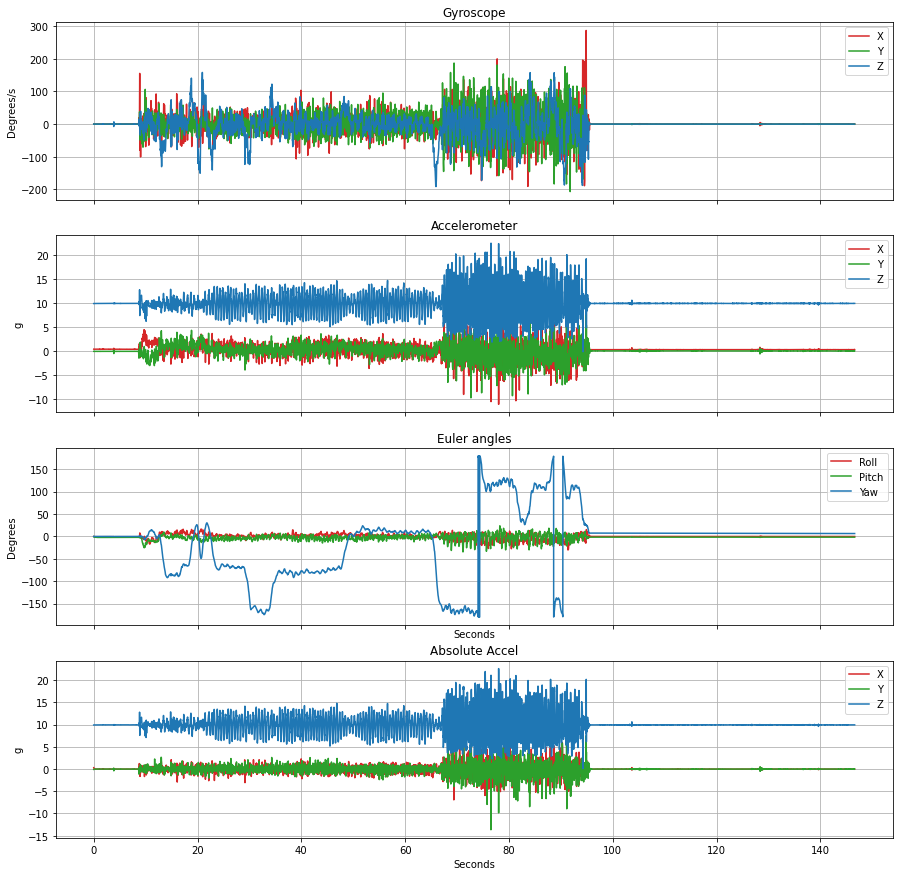

In [11]:
_, axes = plt.subplots(nrows=4, sharex=True, figsize=(15,15))

axes[0].plot(timestamp, gyroscope[:, 0], "tab:red", label="X")
axes[0].plot(timestamp, gyroscope[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, gyroscope[:, 2], "tab:blue", label="Z")
axes[0].set_title("Gyroscope")
axes[0].set_ylabel("Degrees/s")
axes[0].grid()
axes[0].legend()

axes[1].plot(timestamp, accelerometer[:, 0], "tab:red", label="X")
axes[1].plot(timestamp, accelerometer[:, 1], "tab:green", label="Y")
axes[1].plot(timestamp, accelerometer[:, 2], "tab:blue", label="Z")
axes[1].set_title("Accelerometer")
axes[1].set_ylabel("g")
axes[1].grid()
axes[1].legend()

axes[2].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[2].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[2].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[2].set_title("Euler angles")
axes[2].set_xlabel("Seconds")
axes[2].set_ylabel("Degrees")
axes[2].grid()
axes[2].legend()

axes[3].plot(timestamp, absAccel[:, 0], "tab:red", label="X")
axes[3].plot(timestamp, absAccel[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp, absAccel[:, 2], "tab:blue", label="Z")
axes[3].set_title("Absolute Accel")
axes[3].set_xlabel("Seconds")
axes[3].set_ylabel("g")
axes[3].grid()
axes[3].legend()

In [12]:
absAccel

array([[ 3.18057695e-01, -7.58341175e-02,  9.91788613e+00],
       [ 2.66713560e-01, -6.81530518e-02,  9.92409450e+00],
       [ 2.33942561e-01, -5.15113215e-02,  9.93004346e+00],
       ...,
       [-1.48317427e-02,  2.80831541e-02,  9.93233914e+00],
       [-1.11217260e-02,  1.37745261e-02,  9.93596660e+00],
       [ 3.92708027e-03,  3.84026475e-03,  9.94595260e+00]])

NameError: name 'calib_g' is not defined

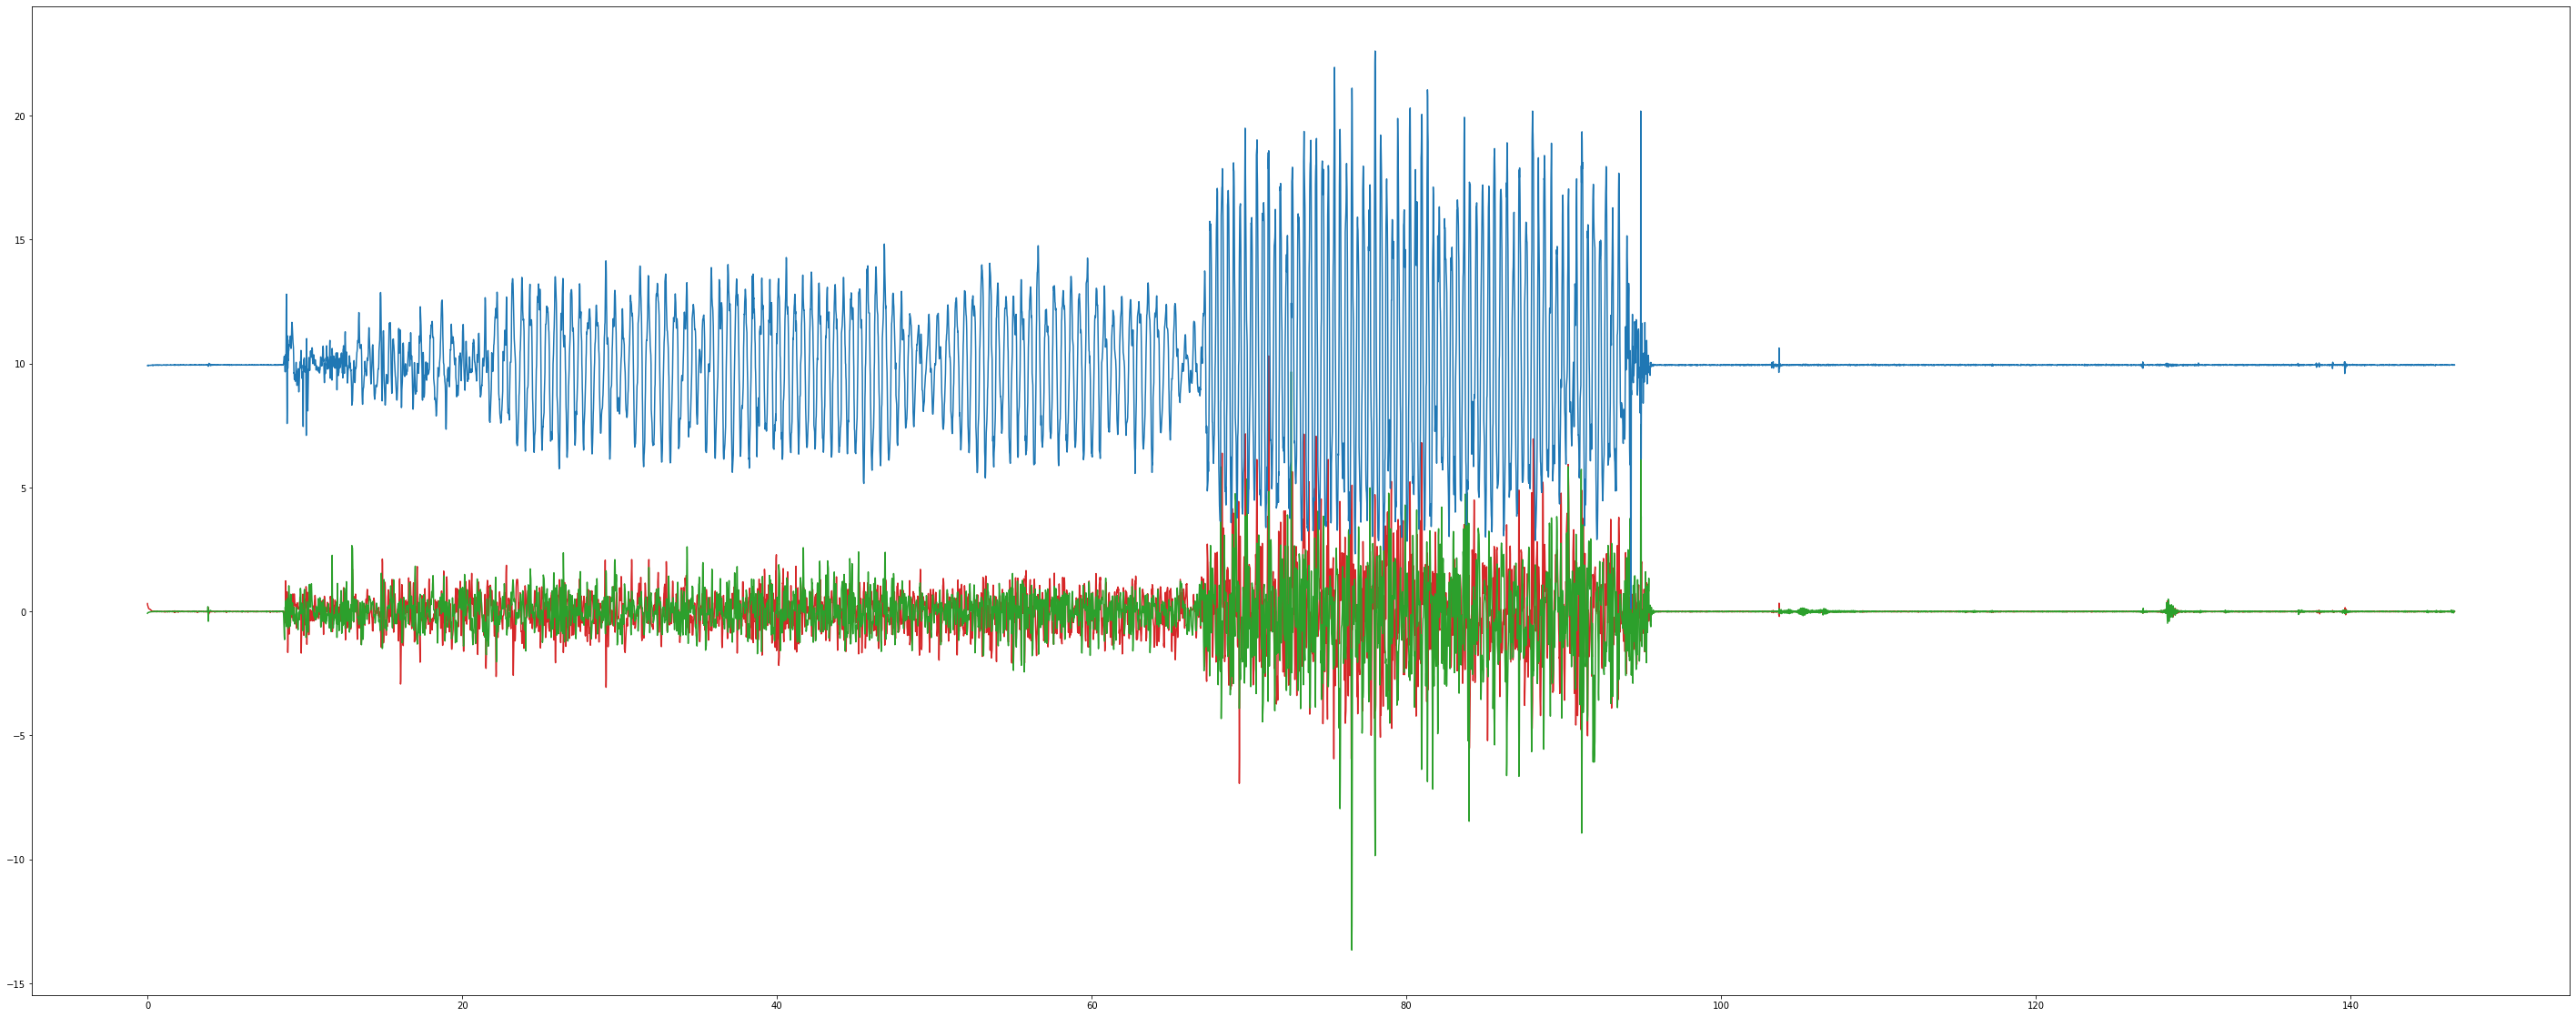

In [13]:
fig = plt.figure(figsize=(50,20))
plt.plot(timestamp, absAccel[:, 0], "tab:red", label="X")
plt.plot(timestamp, absAccel[:, 1], "tab:green", label="Y")
plt.plot(timestamp, absAccel[:, 2], "tab:blue", label="Z")
plt.axhline(calib_g[0])
plt.axhline(calib_g[1])
plt.axhline(calib_g[2])
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)

In [ ]:
calib_g

In [ ]:
index = next(x for x, val in enumerate(timestamp) if val>3)
accelCalib = np.empty(absAccel.shape)
calib_g = []
for indAxis in [0,1,2]:
    noise = sum(absAccel[:index,indAxis])/index
    accelCalib[:,indAxis] = absAccel[:,indAxis] - noise
    calib_g.append(noise)

In [ ]:
totNum = len(t_interval_list)
velo_list = np.empty(absAccel.shape)
posi_list = np.empty(absAccel.shape)
velo_list[0] = [0,0,0]
posi_list[0] = [0,0,0]

for indAxis in [0,1,2]:
    i=0
    while i<totNum:
        if i > 0:
            newVelo = velo_list[i-1,indAxis] + accelCalib[i,indAxis] * t_interval_list[i]
            if abs(newVelo) < 0:
                velo_list[i,indAxis]=0
            else:
                velo_list[i,indAxis]=newVelo
            posi_list[i,indAxis]=(posi_list[i-1,indAxis] + velo_list[i,indAxis] * t_interval_list[i])
        i+=1

In [ ]:
_, axesR = plt.subplots(nrows=3, sharex=True, figsize=(15,15))

axesR[0].plot(timestamp, accelCalib[:, 0], "tab:red", label="X")
axesR[0].plot(timestamp, accelCalib[:, 1], "tab:green", label="Y")
axesR[0].plot(timestamp, accelCalib[:, 2], "tab:blue", label="Z")
axesR[0].set_title("accelCalib")
axesR[0].set_ylabel("m/s^2")
axesR[0].grid()
#axesR[0].set_xlim(0,60)
axesR[0].legend()

axesR[1].plot(timestamp,velo_list[:, 0], "tab:red", label="X")
axesR[1].plot(timestamp, velo_list[:, 1], "tab:green", label="Y")
axesR[1].plot(timestamp, velo_list[:, 2], "tab:blue", label="Z")
axesR[1].set_title("velo_list")
axesR[1].set_ylabel("m/s")
axesR[1].grid()
#axesR[1].set_xlim(0,60)
axesR[1].legend()

axesR[2].plot(timestamp,posi_list[:, 0], "tab:red", label="X")
axesR[2].plot(timestamp,posi_list[:, 1], "tab:green", label="Y")
axesR[2].plot(timestamp,posi_list[:, 2], "tab:blue", label="Z")
axesR[2].set_title("posi_list")
axesR[2].set_ylabel("m")
axesR[2].grid()
#axesR[2].set_xlim(0,60)
#axesR[2].set_ylim(-10,40)
axesR[2].legend()

In [ ]:
fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

# defining all 3 axes

x = posi_list[:, 0]
y = posi_list[:, 1]
z = posi_list[:, 2]
# plotting
ax.plot3D(x, y, z)
plt.show()
